<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/src/CaptumLongformerSequenceClassificationPapersAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [3]:
pip install transformers --quiet

In [4]:
pip install captum --quiet

In [5]:
pip install datasets --quiet

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer, LongformerConfig
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'danielhou13/longformer-finetuned_papers'

# load model
model = LongformerForSequenceClassification.from_pretrained(model_path, num_labels = 2, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

In [10]:
def predict(inputs, position_ids=None):
    output = model(inputs,
                   position_ids=position_ids)
    return output.logits, output.attentions

In [11]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [12]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, truncation = True, add_special_tokens=False, max_length = 512)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                          token_type_ids=None, ref_token_type_ids=None, \
                                          position_ids=None, ref_position_ids=None):
    input_embeddings = model.longformer.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.longformer.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    print(input_embeddings.shape)
    return input_embeddings, ref_input_embeddings

In [13]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(400, 300))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        print(scores.shape)
        ax = fig.add_subplot(12, 1, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(514))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [27]:
def visualize_token2token_onehead(scores_mat, head_num):
    fig, ax = plt.subplots()
    fig.set_figheight(50)
    fig.set_figwidth(50)
    scores_np = np.array(scores_mat[head_num-1])
    print(scores_np.shape)
    c = ax.imshow(scores_np, cmap='viridis')
    fontdict = {'fontsize': 10}
    ax.set_xticks(range(514))
    ax.set_yticks(range(len(all_tokens)))
    ax.set_xticklabels(range(514), rotation=80)
    ax.set_yticklabels(all_tokens, fontdict=fontdict)

    ax.set_xlabel('{} {}'.format("Head", head_num))

    plt.colorbar(c, fraction=0.046, pad=0.04)
    plt.show()

In [15]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(400, 300))
    print(scores_mat.shape)
    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(12, 1, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(514))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [16]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [17]:
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")["test"]

Using custom data configuration danielhou13--cogs402dataset-cc784554b797f843
Reusing dataset parquet (/root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset-cc784554b797f843/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
testval = 923
text = cogs402_ds['text'][testval]
label = cogs402_ds['labels'][testval]
print(label)

0


In [19]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)

position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [20]:
score, attention = predict(input_ids, position_ids)

In [21]:
print(torch.softmax(score, dim = 1))

tensor([[0.9865, 0.0135]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [22]:
# shape -> layer x batch x head x seq_len x attention_window
output_attentions_all = torch.stack(attention)

In [23]:
layer = 11

In [24]:
output_attentions_all_shape = output_attentions_all.shape
print(output_attentions_all_shape)
batch = output_attentions_all_shape[1]
num_heads = output_attentions_all_shape[2]
head_size = 64
all_head_size = 768

torch.Size([12, 1, 12, 514, 514])


In [25]:
# model.config

The attention weight of a token to itself is located at index (1+256). At index 257, the attention_window/2 suceeding and preceding values are the attention weights of the attention_window/2 suceeding and preceding tokens

(514, 514)


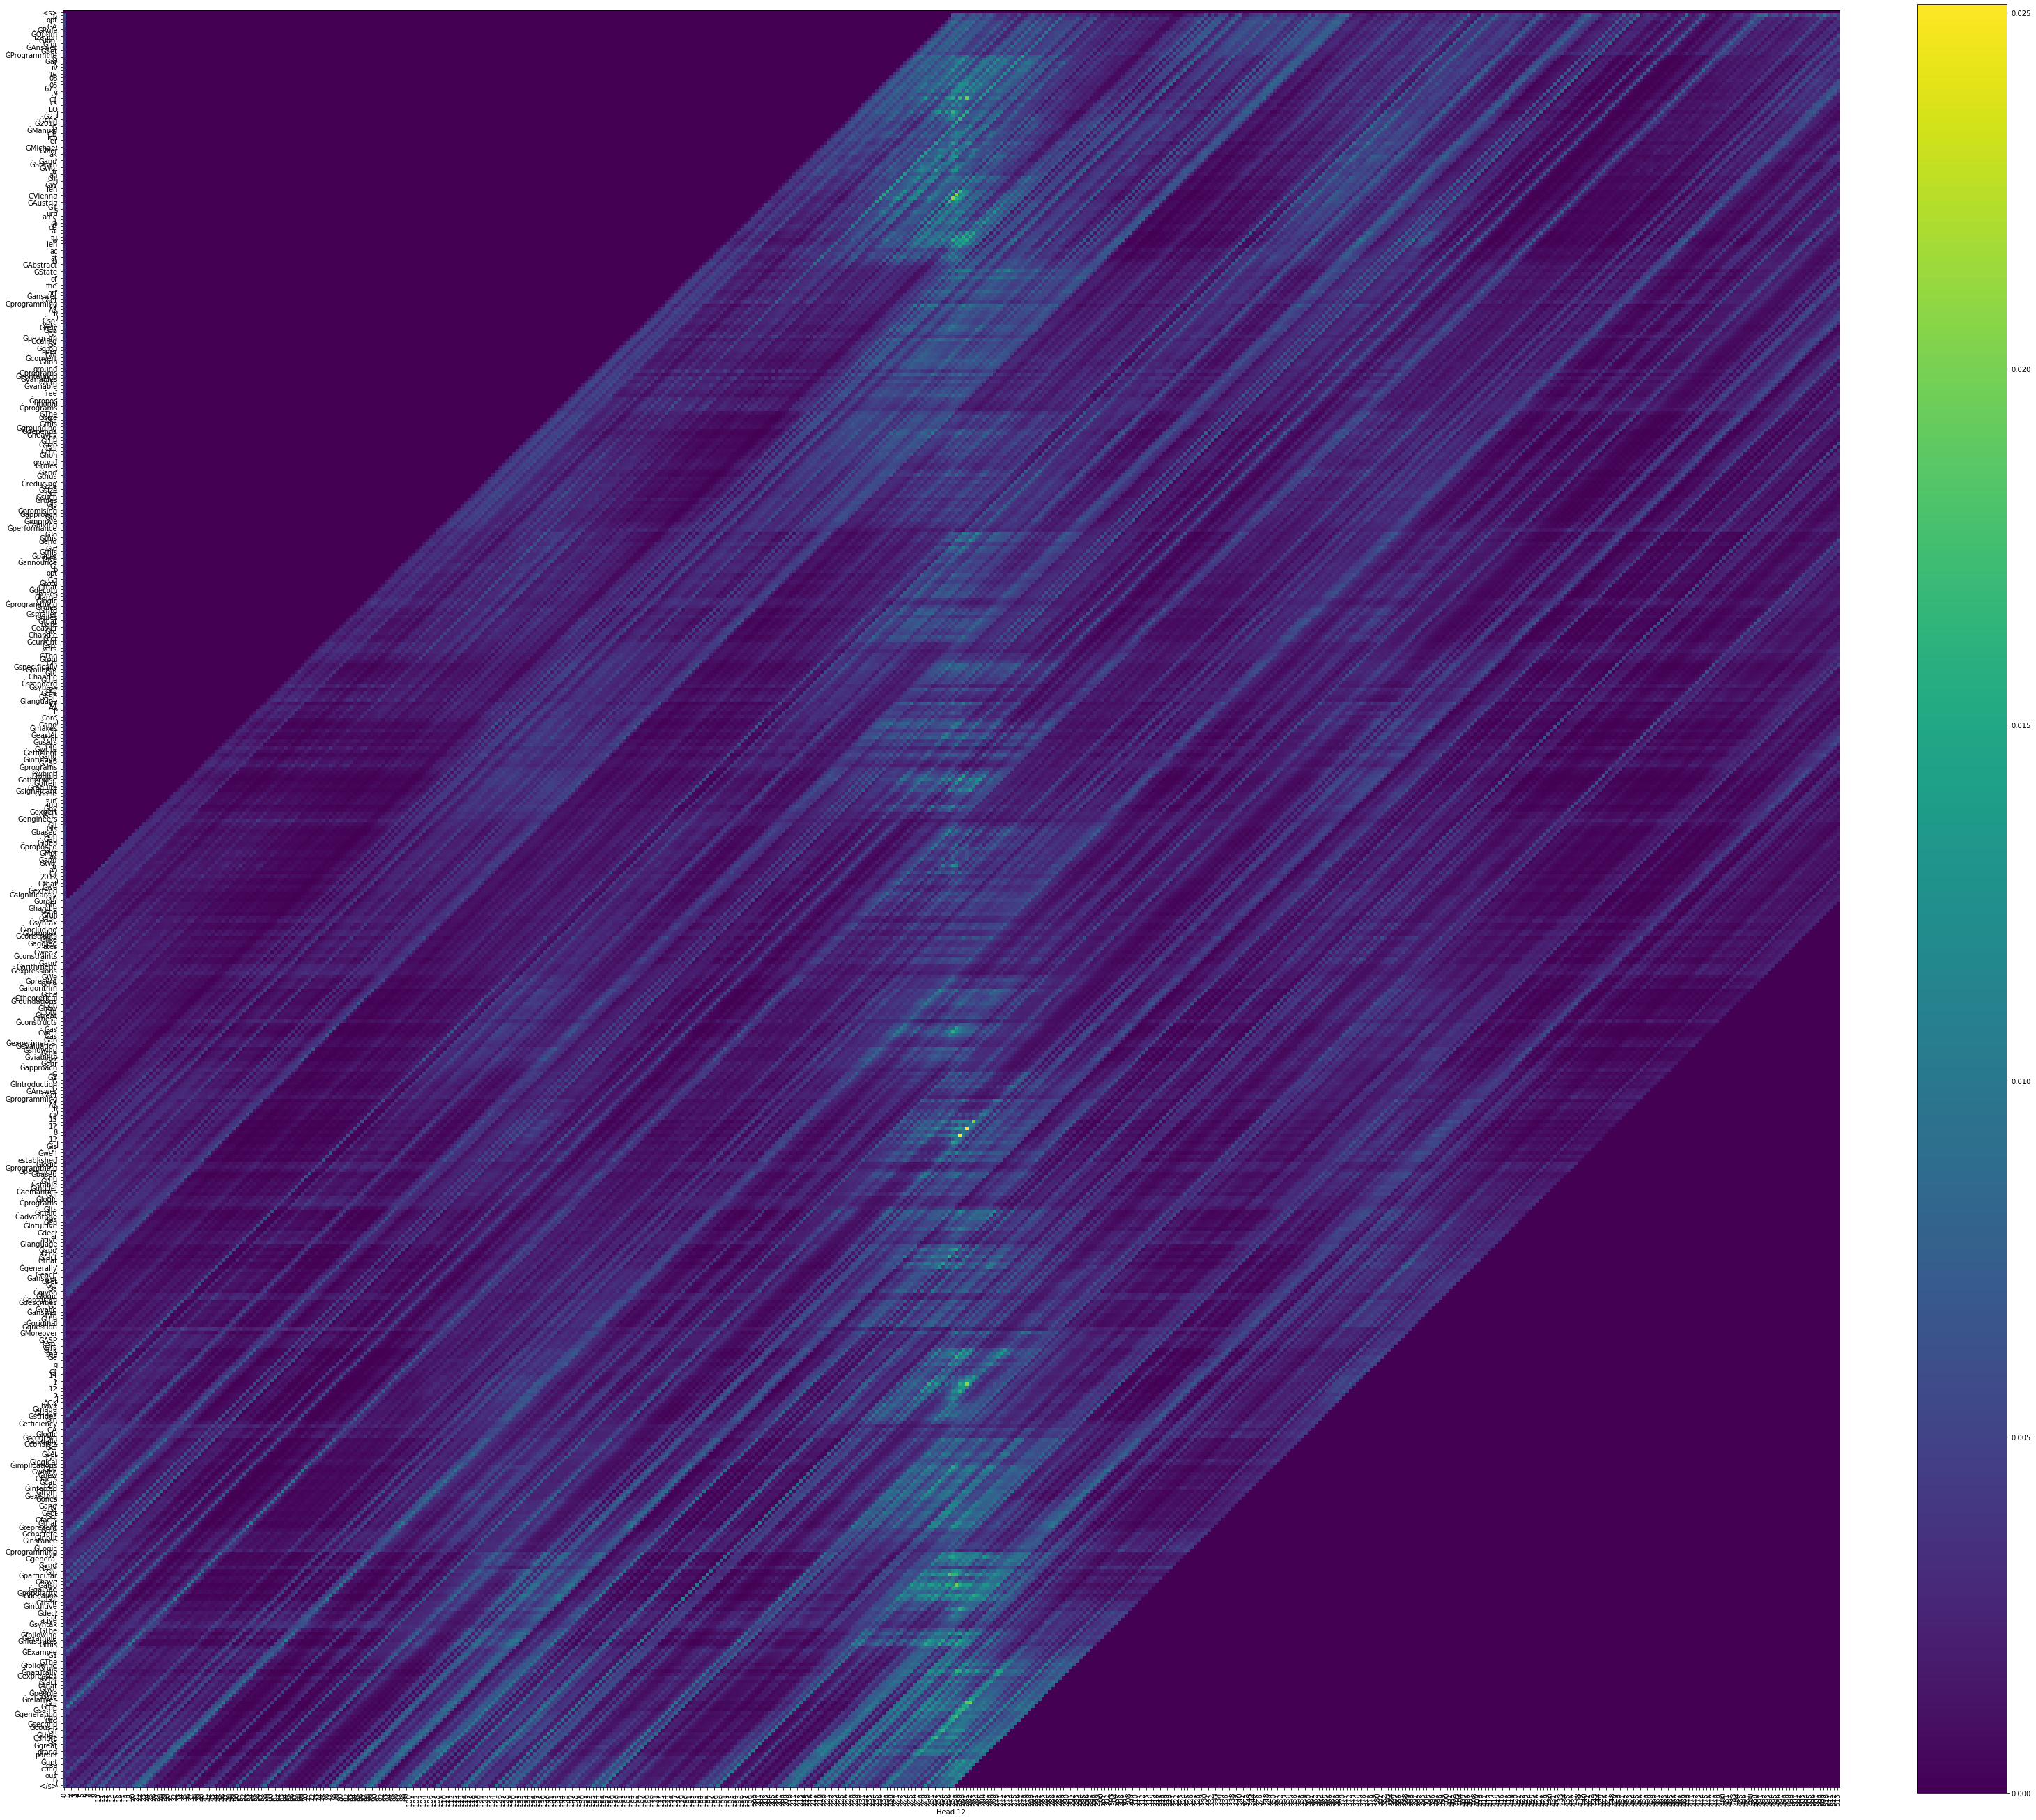

In [28]:
visualize_token2token_onehead(output_attentions_all[layer].squeeze().detach().cpu().numpy(), 12)

In [ ]:
test = output_attentions_all[11][0][11].detach().cpu().numpy()
print(test.shape)
print(test[1], test[1][257])
print(test[2])
print(test[-1])
max = test.argmax(axis=1)
print(max)


In [ ]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')